# Импорты

In [83]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, adjusted_rand_score
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Мои реализации выбора признаков

In [58]:
def embedded_method(X_train, y_train, n_features=0.9, C=0.01):
    svc = LinearSVC(C=C, penalty="l1", dual=False, random_state=21)
    svc.fit(X_train, y_train)

    feature_coefficients = np.abs(svc.coef_)[0]
    if type(n_features) is float:
        n_features = int(X_train.shape[1] * n_features)

    selected_indices = np.argsort(feature_coefficients)[-n_features:]
    selected_features = X_train.columns[selected_indices]

    return selected_features


def wrapper_method(X_train, y_train, model=None, n_features=0.9):
    if model is None:
        model = LogisticRegression(max_iter=500)

    selected_features = []
    unused_features = list(X_train.columns)

    if type(n_features) is float:
        n_features = int(X_train.shape[1] * n_features)

    for i in tqdm(range(n_features)):
        scores = []
        for feature in unused_features:
            current_features = selected_features + [feature]
            model.fit(X_train[current_features], y_train)
            score = model.score(X_train[current_features], y_train)
            scores.append((score, feature))

        scores.sort(reverse=True, key=lambda x: x[0])
        best_feature = scores[0][1]
        selected_features.append(best_feature)
        unused_features.remove(best_feature)

    return selected_features


def filter_method(X_train, y_train, threshold=0.1, n_features=None):
    correlation_coefficients = []
    for column in X_train.columns:
        x = X_train[column]
        y = y_train
        mean_x = np.mean(x)
        mean_y = np.mean(y)
        numerator = np.sum((x - mean_x) * (y - mean_y))
        denominator = np.sqrt(np.sum((x - mean_x) ** 2) * np.sum((y - mean_y) ** 2))
        corr = numerator / denominator if denominator != 0 else 0
        correlation_coefficients.append(corr)

    correlation_coefficients = pd.Series(correlation_coefficients, index=X_train.columns)

    if n_features is None:
        selected_features = correlation_coefficients[correlation_coefficients.abs() > threshold].index
    else:
        if type(n_features) is float:
            n_features = int(X_train.shape[1] * n_features)
        correlation_coefficients = abs(correlation_coefficients).sort_values(ascending=False)
        selected_features = correlation_coefficients[:n_features].index

    return selected_features

# Подготовка данных

In [34]:
df = pd.read_csv("SMS.tsv", sep='\t')
df = df.head(500)

df.loc[df['class'] == 'spam', 'class'] = 1
df.loc[df['class'] == 'ham', 'class'] = 0

X = df['text']
Y = df['class']

vectorizer = CountVectorizer()
X = pd.DataFrame(vectorizer.fit_transform(X).toarray(), columns=vectorizer.get_feature_names_out())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21,
                                                    stratify=df['class'])

Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

X.head()

,000,0125698789,0207,021,03,07046744435,07123456789,07732584351,07742676969,07781482378,...,yo,yoga,you,your,yours,yourself,yr,yummy,yup,ú1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Библиотечные методы выбора признаков

In [36]:
rfc = RandomForestClassifier(random_state=42)
select_from_model = SelectFromModel(estimator=rfc, prefit=False, max_features=30, threshold=-np.inf)
select_from_model.fit(X_train, Y_train)
X_train_sfm = select_from_model.transform(X_train)
X_test_sfm = select_from_model.transform(X_test)
selected_features_sfm = X_train.columns[select_from_model.get_support()]

print("SelectFromModel:", list(selected_features_sfm))

SelectFromModel: ['1000', '150p', '16', '50', 'awarded', 'call', 'camera', 'claim', 'code', 'customer', 'free', 'from', 'guaranteed', 'mobile', 'msg', 'our', 'prize', 'reply', 'ringtone', 'service', 'text', 'to', 'txt', 'uk', 'ur', 'urgent', 'wkly', 'word', 'www', 'your']


In [51]:
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=30)
rfe.fit(X_train, Y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
selected_features_rfe = X_train.columns[rfe.support_]

print("RFE:", list(selected_features_rfecv))

RFE: ['100', '1000', '150p', '50', 'bonus', 'call', 'claim', 'customer', 'dating', 'free', 'from', 'hear', 'me', 'mobile', 'msg', 'new', 'now', 'or', 'prize', 'ringtone', 'service', 'so', 'sptv', 'text', 'to', 'txt', 'uk', 'ur', 'wap', 'www']


In [37]:
skb = SelectKBest(score_func=chi2, k=30)
X_train_skb = skb.fit_transform(X_train, Y_train)
X_test_skb = skb.transform(X_test)
selected_features_skb = X_train.columns[skb.get_support(indices=True)]

print("SelectKBest:", list(selected_features_skb))

SelectKBest: ['100', '1000', '150p', '16', '500', 'awarded', 'call', 'camera', 'claim', 'customer', 'free', 'from', 'guaranteed', 'mobile', 'msg', 'nokia', 'or', 'our', 'prize', 'reply', 'ringtone', 'service', 'stop', 'text', 'to', 'txt', 'uk', 'ur', 'www', 'your']


## Выбор 30 признаков моими методами

In [53]:
embedded_features = list(embedded_method(X_train, Y_train, 30))
print("embedded_method:", embedded_features)

embedded_method: ['fallen', 'falconerf', 'fair', 'fainting', 'faded', 'factory', 'facebook', 'face', 'fa', 'f4q', 'expression', 'expires', 'evaporated', 'experience', 'exist', 'exercise', 'excited', 'exam', 'ex', 'evo', 'everywhere', 'everything', 'everyone', 'every', 'ever', 'evening', 'even', 'expect', 'ú1', 'to']


In [61]:
wrapper_features = list(wrapper_method(X_train, Y_train, n_features=30))
print("wrapper_method:", wrapper_features)

100%|██████████| 30/30 [10:09<00:00, 20.32s/it]

wrapper_method: ['txt', 'mobile', 'claim', 'www', 'dogging', 'bit', 'cash', '150ppm', '16', 'box', '000', '0125698789', '021', '03', '07046744435', '07123456789', '07732584351', '07781482378', 'delivery', '0800', '08000930705', '08002986030', '0844', '08708800282', '08452810075over18', '08712300220', '0871277810810', '08717205546', '09058094455', '08002986906']


In [55]:
filter_features = list(filter_method(X_train, Y_train, n_features=30))
print("filter_method:", filter_features)

filter_method: ['txt', 'free', 'to', 'www', 'claim', 'call', 'mobile', 'prize', 'reply', 'uk', 'awarded', '16', '150p', 'guaranteed', '500', '1000', 'customer', 'or', 'msg', 'nokia', 'camera', '100', 'our', 'your', 'text', 'ringtone', 'service', 'ur', 'bonus', 'wkly']


# Качество работы до и после выбора признаков

In [49]:
lr = LogisticRegression(max_iter=1000)
rfc = RandomForestClassifier(random_state=42)
svc = LinearSVC(max_iter=1000)

In [63]:
print("Logistic Regression:")
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
print(f"До выбора признаков: {accuracy_score(Y_test, Y_pred):.2f}")

for method_name, (X_train_selected, X_test_selected) in zip(
    ["SelectKBest", "RFE", "SelectFromModel", "my embedded", "my wrapper", "my filter"],
    [(X_train_skb, X_test_skb), (X_train_rfe, X_test_rfe), (X_train_sfm, X_test_sfm),
     (X_train[embedded_features], X_test[embedded_features]), (X_train[wrapper_features], X_test[wrapper_features]),
     (X_train[filter_features], X_test[filter_features])],
):
    lr.fit(X_train_selected, Y_train)
    Y_pred_selected = lr.predict(X_test_selected)
    print(f"После выбора признаков ({method_name}): {accuracy_score(Y_test, Y_pred_selected):.2f}")

Logistic Regression:
До выбора признаков: 0.93
После выбора признаков (SelectKBest): 0.93
После выбора признаков (RFE): 0.95
После выбора признаков (SelectFromModel): 0.93
После выбора признаков (my embedded): 0.87
После выбора признаков (my wrapper): 0.91
После выбора признаков (my filter): 0.93


In [65]:
print("Random Forest:")
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print(f"До выбора признаков: {accuracy_score(Y_test, Y_pred):.2f}")

for method_name, (X_train_selected, X_test_selected) in zip(
    ["SelectKBest", "RFE", "SelectFromModel", "my embedded", "my wrapper", "my filter"],
    [(X_train_skb, X_test_skb), (X_train_rfe, X_test_rfe), (X_train_sfm, X_test_sfm),
     (X_train[embedded_features], X_test[embedded_features]), (X_train[wrapper_features], X_test[wrapper_features]),
     (X_train[filter_features], X_test[filter_features])],
):
    rfc.fit(X_train_selected, Y_train)
    Y_pred_selected = rfc.predict(X_test_selected)
    print(f"После выбора признаков ({method_name}): {accuracy_score(Y_test, Y_pred_selected):.2f}")

Random Forest:
До выбора признаков: 0.93
После выбора признаков (SelectKBest): 0.93
После выбора признаков (RFE): 0.95
После выбора признаков (SelectFromModel): 0.92
После выбора признаков (my embedded): 0.87
После выбора признаков (my wrapper): 0.91
После выбора признаков (my filter): 0.94


In [66]:
print("SVC:")
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
print(f"До выбора признаков: {accuracy_score(Y_test, Y_pred):.2f}")

for method_name, (X_train_selected, X_test_selected) in zip(
    ["SelectKBest", "RFE", "SelectFromModel", "my embedded", "my wrapper", "my filter"],
    [(X_train_skb, X_test_skb), (X_train_rfe, X_test_rfe), (X_train_sfm, X_test_sfm),
     (X_train[embedded_features], X_test[embedded_features]), (X_train[wrapper_features], X_test[wrapper_features]),
     (X_train[filter_features], X_test[filter_features])],
):
    svc.fit(X_train_selected, Y_train)
    Y_pred_selected = svc.predict(X_test_selected)
    print(f"После выбора признаков ({method_name}): {accuracy_score(Y_test, Y_pred_selected):.2f}")

SVC:
До выбора признаков: 0.95
После выбора признаков (SelectKBest): 0.93
После выбора признаков (RFE): 0.96
После выбора признаков (SelectFromModel): 0.94
После выбора признаков (my embedded): 0.87
После выбора признаков (my wrapper): 0.91
После выбора признаков (my filter): 0.95


# Кластеризация

In [94]:
kmeans = KMeans(n_clusters=2, random_state=42)

kmeans_labels_before = kmeans.fit_predict(X_train)
score_before = adjusted_rand_score(Y_train, kmeans_labels_before)

kmeans_labels_after = kmeans.fit_predict(X_train_skb)
score_after = adjusted_rand_score(Y_train, kmeans_labels_after)

print(f"Качество кластеризации (ARI) до выбора признаков: {score_before:.2f}")
print(f"Качество кластеризации (ARI) после выбора признаков (SelectKBest): {score_after:.2f}")

Качество кластеризации (ARI) до выбора признаков: -0.00
Качество кластеризации (ARI) после выбора признаков (SelectKBest): 0.19


# PCA и tSNE

In [85]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state=42)

X_pca = pca.fit_transform(X_train)
X_tsne = tsne.fit_transform(X_train)

X_train_skb_pca = pca.fit_transform(X_train_skb)
X_train_skb_tsne = tsne.fit_transform(X_train_skb)

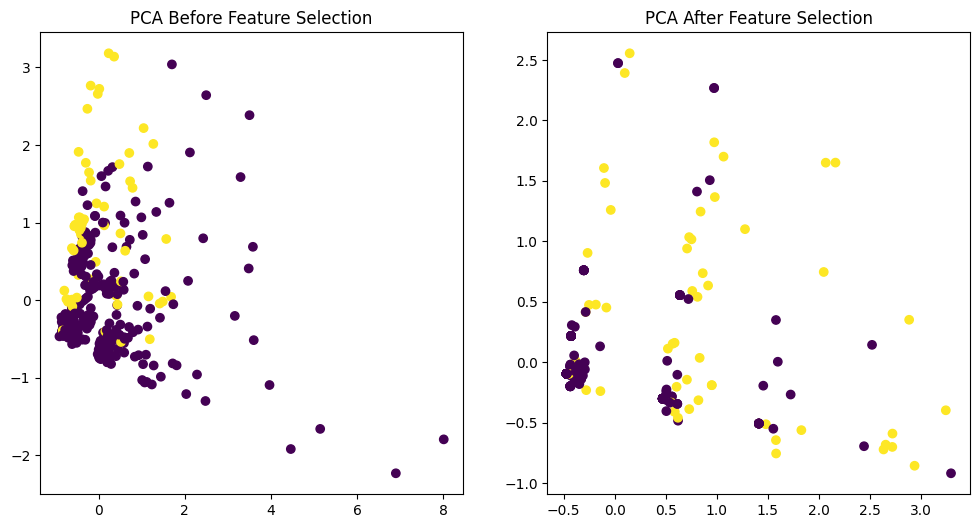

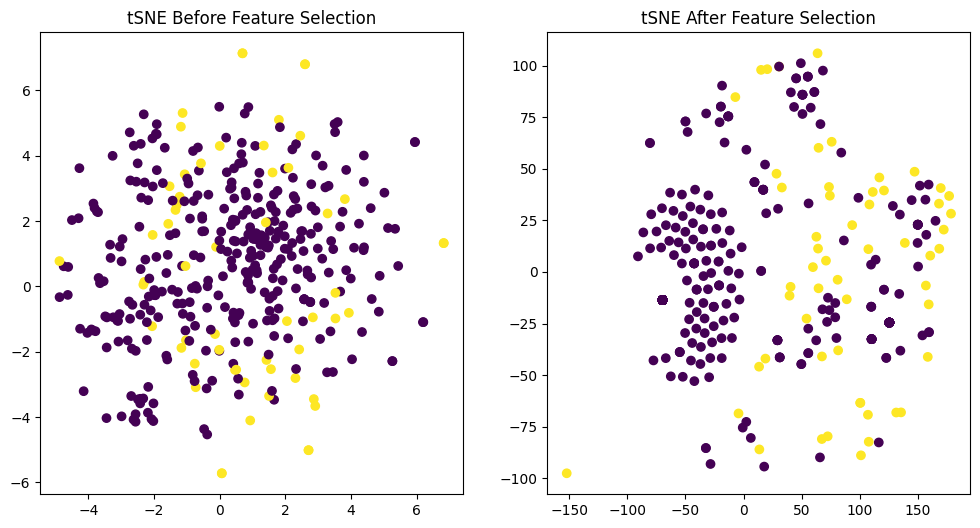

In [93]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_train)
plt.title("PCA Before Feature Selection")

plt.subplot(1, 2, 2)
plt.scatter(X_train_skb_pca[:, 0], X_train_skb_pca[:, 1], c=Y_train)
plt.title("PCA After Feature Selection")

plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_train)
plt.title("tSNE Before Feature Selection")

plt.subplot(1, 2, 2)
plt.scatter(X_train_skb_tsne[:, 0], X_train_skb_tsne[:, 1], c=Y_train)
plt.title("tSNE After Feature Selection")

plt.show()